<a href="https://colab.research.google.com/github/Lincoln-coimbra/Analisecovid/blob/main/Va3pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("AnaliseBeneficios").getOrCreate()



In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Leitura do CSV com parâmetros seguros
df = spark.read.csv(
    csv_path,
    header=True,
    inferSchema=True,
    sep=";",
    encoding="utf-8", # Change to utf-8 to better handle BOM if present
    quote='"',
    multiLine=True
)

# Inspeção inicial
df.show(5)
df.printSchema()
df.columns

+---+--------------------+-------+-----------------+---------------+
| UF|           Município|Mês/Ano|Valor Transferido|Programa Social|
+---+--------------------+-------+-----------------+---------------+
| SC|            IMBITUBA| jun/25|        -7.842,12|  Seguro Defeso|
| TO|PALMEIRAS DO TOCA...| jun/25|        -7.390,81|  Seguro Defeso|
| BA|              ABAÍRA| jun/25|        -6.072,00|  Seguro Defeso|
| CE|         JAGUARETAMA| jun/25|        -4.270,00|  Seguro Defeso|
| RS|   SÃO JOSÉ DO NORTE| jun/25|        -1.518,00|  Seguro Defeso|
+---+--------------------+-------+-----------------+---------------+
only showing top 5 rows

root
 |-- UF: string (nullable = true)
 |-- Município: string (nullable = true)
 |-- Mês/Ano: string (nullable = true)
 |-- Valor Transferido: string (nullable = true)
 |-- Programa Social: string (nullable = true)



['UF', 'Município', 'Mês/Ano', 'Valor Transferido', 'Programa Social']

In [16]:
from pyspark.sql.functions import col, to_date, regexp_replace


# 1) Converter valor para número
# Remove thousand separators (dots)
df = df.withColumn("ValorTransferido", regexp_replace(col("Valor Transferido"), "\\.", ""))
# Replace decimal comma with a decimal point
df = df.withColumn("ValorTransferido", regexp_replace(col("ValorTransferido"), ",", "."))
# Cast to double
df = df.withColumn("ValorTransferido", col("ValorTransferido").cast("double"))

# 2) Converter MesAno para date (representa o primeiro dia do mês)
df = df.withColumn("MesAno", to_date(col("Mês/Ano"), "MMM/yy"))

# 3) Remover linhas claramente inválidas
df = df.dropna(subset=["UF", "Município", "MesAno", "ValorTransferido", "Programa Social"])

# 4) Remover duplicados (se houver)
df = df.dropDuplicates()

# Conferir resultado
df.show(5)
df.printSchema()

+---+-----------------+-------+-----------------+------------------+----------------+----------+
| UF|        Município|Mês/Ano|Valor Transferido|   Programa Social|ValorTransferido|    MesAno|
+---+-----------------+-------+-----------------+------------------+----------------+----------+
| CE|             TAUÁ| jun/25|         6.072,00|     Seguro Defeso|          6072.0|2025-06-01|
| PB|            PICUÍ| jun/25|        13.200,00|    Garantia-Safra|         13200.0|2025-06-01|
| SP|       DIRCE REIS| jun/25|        44.379,00|Novo Bolsa Família|         44379.0|2025-06-01|
| RJ|SÃO JOÃO DA BARRA| jun/25|        47.058,00|     Seguro Defeso|         47058.0|2025-06-01|
| SP|             ÓLEO| jun/25|        57.686,32|               BPC|        57686.32|2025-06-01|
+---+-----------------+-------+-----------------+------------------+----------------+----------+
only showing top 5 rows

root
 |-- UF: string (nullable = true)
 |-- Município: string (nullable = true)
 |-- Mês/Ano: string (

In [17]:
from pyspark.sql.functions import regexp_replace, col

# Remover letras/símbolos
df = df.withColumn("ValorTransferido",
                   regexp_replace(col("ValorTransferido"), r"[^0-9,\.]", ""))

# Trocar vírgula por ponto
df = df.withColumn("ValorTransferido",
                   regexp_replace(col("ValorTransferido"), ",", "."))

# Converter para número
df = df.withColumn("ValorTransferido", col("ValorTransferido").cast("double"))

# Filtrar valores absurdos (exemplo: acima de 1 bilhão)
df = df.filter(col("ValorTransferido") < 1_000_000_000)

df.show(5)

+---+-----------------+-------+-----------------+------------------+----------------+----------+
| UF|        Município|Mês/Ano|Valor Transferido|   Programa Social|ValorTransferido|    MesAno|
+---+-----------------+-------+-----------------+------------------+----------------+----------+
| CE|             TAUÁ| jun/25|         6.072,00|     Seguro Defeso|          6072.0|2025-06-01|
| PB|            PICUÍ| jun/25|        13.200,00|    Garantia-Safra|         13200.0|2025-06-01|
| SP|       DIRCE REIS| jun/25|        44.379,00|Novo Bolsa Família|         44379.0|2025-06-01|
| RJ|SÃO JOÃO DA BARRA| jun/25|        47.058,00|     Seguro Defeso|         47058.0|2025-06-01|
| SP|             ÓLEO| jun/25|        57.686,32|               BPC|        57686.32|2025-06-01|
+---+-----------------+-------+-----------------+------------------+----------------+----------+
only showing top 5 rows



In [18]:
from pyspark.sql.functions import sum, avg, count, month, year, desc, format_number

# Total por UF
total_por_uf = (df.groupBy("UF")
                  .agg(sum("ValorTransferido").alias("Total"))
                  .orderBy(desc("Total")))
total_por_uf.withColumn("Total Formatado", format_number(col("Total"), 2)).show(10)

# Top 10 municípios que mais receberam
top_municipios = (df.groupBy("Município")
                    .agg(sum("ValorTransferido").alias("Total"))
                    .orderBy(desc("Total"))
                    .limit(10))
top_municipios.withColumn("Total Formatado", format_number(col("Total"), 2)).show()

# Total por programa social
total_por_programa = (df.groupBy("Programa Social")
                        .agg(sum("ValorTransferido").alias("Total"))
                        .orderBy(desc("Total")))
total_por_programa.withColumn("Total Formatado", format_number(col("Total"), 2)).show(10)

total_por_programa.select(
    "Programa Social",
    "Total",
    format_number("Total", 2).alias("TotalFormatado")
).show(10, truncate=False)

#media de valor por Municipio

df.groupBy("Município") \
  .agg(avg("ValorTransferido").alias("Media")) \
  .orderBy(desc("Media")) \
  .show(10)


from pyspark.sql.functions import sum, col, format_number

df.filter(col("UF") == "GO") \
  .groupBy("Município") \
  .agg(sum("ValorTransferido").alias("Total")) \
  .orderBy(desc("Total")) \
  .show(10)

# Filtros (exemplos)
# Benefícios em uma UF específica
df.filter(col("UF") == "MA").show(5)

# Benefícios de um programa específico
df.filter(col("Programa Social").contains("Auxílio")).show(5)

+---+--------------------+---------------+
| UF|               Total|Total Formatado|
+---+--------------------+---------------+
| MG| 5.397797479600002E8| 539,779,747.96|
| SP| 3.652048199299999E8| 365,204,819.93|
| PR| 2.457424944900001E8| 245,742,494.49|
| BA|2.2045555476999992E8| 220,455,554.77|
| RS|1.9992623609000012E8| 199,926,236.09|
| PB|1.5902836039000008E8| 159,028,360.39|
| PI|1.5075211505000004E8| 150,752,115.05|
| MA|1.4296539360999998E8| 142,965,393.61|
| GO|      1.3522680689E8| 135,226,806.89|
| SC|1.2104584420999996E8| 121,045,844.21|
+---+--------------------+---------------+
only showing top 10 rows

+------------+------------------+---------------+
|   Município|             Total|Total Formatado|
+------------+------------------+---------------+
| NOVA OLINDA|        3664904.52|   3,664,904.52|
|   CANTAGALO|3417389.6399999997|   3,417,389.64|
|    PALMITAL|        3409115.83|   3,409,115.83|
|  NATIVIDADE|        3201995.37|   3,201,995.37|
|SÃO DOMINGOS|3022729.

In [19]:
from pyspark.sql.functions import sum, col, format_number

def get_formatted_total_for_uf(dataframe, uf_code):
    """
    Calculates the total transferred value for a given UF and returns it formatted.

    Args:
        dataframe (pyspark.sql.DataFrame): The input DataFrame.
        uf_code (str): The UF code (e.g., "GO", "MG") to filter by.

    Returns:
        pyspark.sql.DataFrame: A DataFrame containing the formatted total for the specified UF.
    """
    total_uf = (dataframe.filter(col("UF") == uf_code.upper())
                         .agg(sum("ValorTransferido").alias(f"Total{uf_code.upper()}")))
    return total_uf.select(
        format_number(f"Total{uf_code.upper()}", 2).alias(f"Total{uf_code.upper()}Formatado")
    )

# Example usage:
# Calculate and display total for GO
print("Total for GO:")
get_formatted_total_for_uf(df, "GO").show()

# Calculate and display total for MG
print("Total for MG:")
get_formatted_total_for_uf(df, "MG").show()

Total for GO:
+----------------+
|TotalGOFormatado|
+----------------+
|  135,226,806.89|
+----------------+

Total for MG:
+----------------+
|TotalMGFormatado|
+----------------+
|  539,779,747.96|
+----------------+



In [20]:
# Filtro dinâmico por UF
uf_pesquisa = input("Digite a UF para pesquisar (ex: SP, MG): ")

df.filter(col("UF") == uf_pesquisa.upper()).show(5)

Digite a UF para pesquisar (ex: SP, MG): sp
+---+-----------+-------+-----------------+------------------+----------------+----------+
| UF|  Município|Mês/Ano|Valor Transferido|   Programa Social|ValorTransferido|    MesAno|
+---+-----------+-------+-----------------+------------------+----------------+----------+
| SP| DIRCE REIS| jun/25|        44.379,00|Novo Bolsa Família|         44379.0|2025-06-01|
| SP|       ÓLEO| jun/25|        57.686,32|               BPC|        57686.32|2025-06-01|
| SP|    LAVÍNIA| jun/25|       135.057,00|Novo Bolsa Família|        135057.0|2025-06-01|
| SP| OURO VERDE| jun/25|       611.282,00|Novo Bolsa Família|        611282.0|2025-06-01|
| SP|MORRO AGUDO| jun/25|     1.042.937,47|               BPC|      1042937.47|2025-06-01|
+---+-----------+-------+-----------------+------------------+----------------+----------+
only showing top 5 rows



In [21]:
from pyspark.sql.functions import format_number, col

# Registrar view temporária
df.createOrReplaceTempView("beneficios")

# Total por UF (SQL)
spark.sql("""
  SELECT UF, SUM(ValorTransferido) AS Total
  FROM beneficios
  GROUP BY UF
  ORDER BY Total DESC
  LIMIT 10
""").withColumn("Total Formatado", format_number(col("Total"), 2)).show()

# Evolução mensal por programa
spark.sql("""
  SELECT YEAR(MesAno) AS Ano, MONTH(MesAno) AS Mes, `Programa Social`,
         SUM(ValorTransferido) AS Total
  FROM beneficios
  GROUP BY Ano, Mes, `Programa Social`
  ORDER BY Ano, Mes, Total DESC
""").withColumn("Total Formatado", format_number(col("Total"), 2)).show(20)

# Média por município
spark.sql("""
  SELECT `Município`, AVG(ValorTransferido) AS MediaValor
  FROM beneficios
  GROUP BY `Município`
  ORDER BY MediaValor DESC
  LIMIT 10
""").withColumn("MediaValor Formatada", format_number(col("MediaValor"), 2)).show()

+---+--------------------+---------------+
| UF|               Total|Total Formatado|
+---+--------------------+---------------+
| MG| 5.397797479600002E8| 539,779,747.96|
| SP| 3.652048199299999E8| 365,204,819.93|
| PR| 2.457424944900001E8| 245,742,494.49|
| BA|2.2045555476999992E8| 220,455,554.77|
| RS|1.9992623609000012E8| 199,926,236.09|
| PB|1.5902836039000008E8| 159,028,360.39|
| PI|1.5075211505000004E8| 150,752,115.05|
| MA|1.4296539360999998E8| 142,965,393.61|
| GO|      1.3522680689E8| 135,226,806.89|
| SC|1.2104584420999996E8| 121,045,844.21|
+---+--------------------+---------------+

+----+---+--------------------+--------------------+----------------+
| Ano|Mes|     Programa Social|               Total| Total Formatado|
+----+---+--------------------+--------------------+----------------+
|2025|  6|  Novo Bolsa Família|       1.528375138E9|1,528,375,138.00|
|2025|  6|                 BPC| 1.414158341999999E9|1,414,158,342.00|
|2025|  6|       Seguro Defeso|1.99065872989999

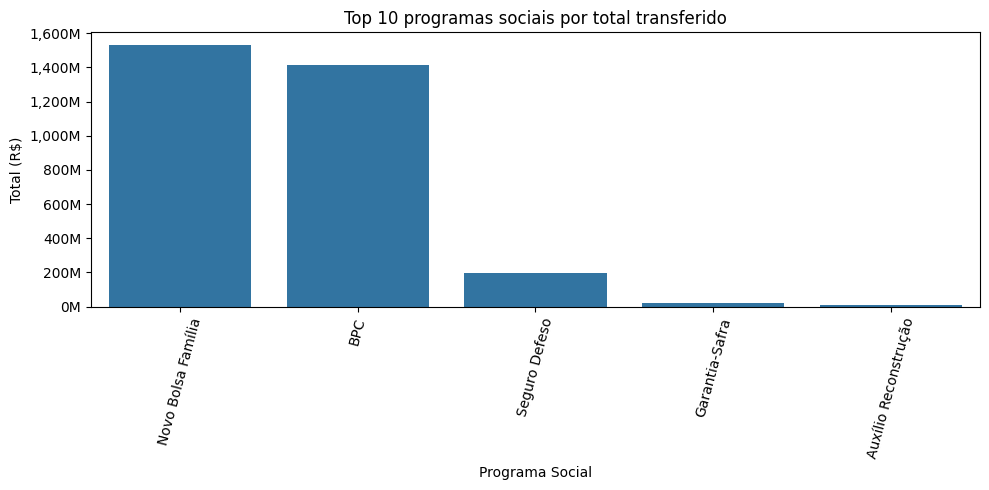

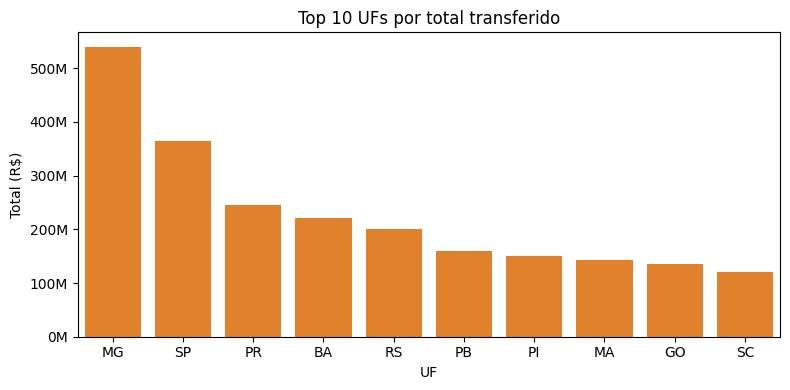

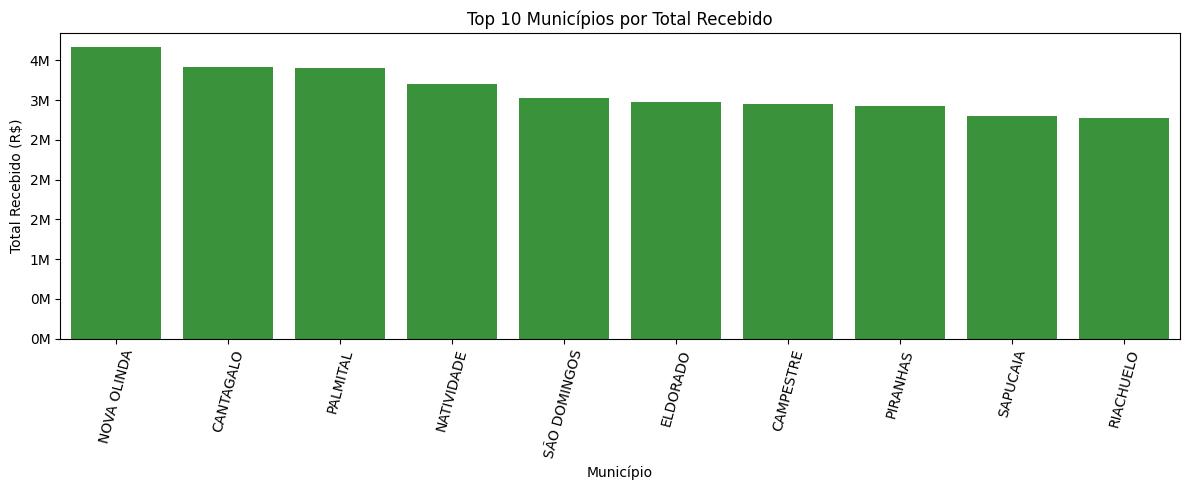

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from pyspark.sql.functions import avg, sum, desc # Added sum for total values

def millions_formatter(x, pos):
    """
    Formats a number as 'X M' (e.g., 1000000 becomes '1 M')
    """
    return f'{x*1e-6:,.0f}M'

# 1) Top 10 programas por total
pdf_prog = (df.groupBy("Programa Social")
              .agg(sum("ValorTransferido").alias("Total"))
              .orderBy(desc("Total"))
              .limit(10)
              .toPandas())

plt.figure(figsize=(10,5))
sns.barplot(data=pdf_prog, x="Programa Social", y="Total", color="#1f77b4")
plt.xticks(rotation=75)
plt.title("Top 10 programas sociais por total transferido")
plt.xlabel("Programa Social")
plt.ylabel("Total (R$)")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

# 2) Total por UF (top 10)
pdf_uf = (df.groupBy("UF")
            .agg(sum("ValorTransferido").alias("Total"))
            .orderBy(desc("Total"))
            .limit(10)
            .toPandas())

plt.figure(figsize=(8,4))
sns.barplot(data=pdf_uf, x="UF", y="Total", color="#ff7f0e")
plt.title("Top 10 UFs por total transferido")
plt.xlabel("UF")
plt.ylabel("Total (R$)")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

# 3) Top 10 Municípios por Total Recebido (updated from average)
pdf_total_municipio = (df.groupBy("Município")
                         .agg(sum("ValorTransferido").alias("Total"))
                         .orderBy(desc("Total"))
                         .limit(10)
                         .toPandas())

plt.figure(figsize=(12,5))
sns.barplot(data=pdf_total_municipio, x="Município", y="Total", color="#2ca02c")
plt.xticks(rotation=75)
plt.title("Top 10 Municípios por Total Recebido")
plt.xlabel("Município")
plt.ylabel("Total Recebido (R$)")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

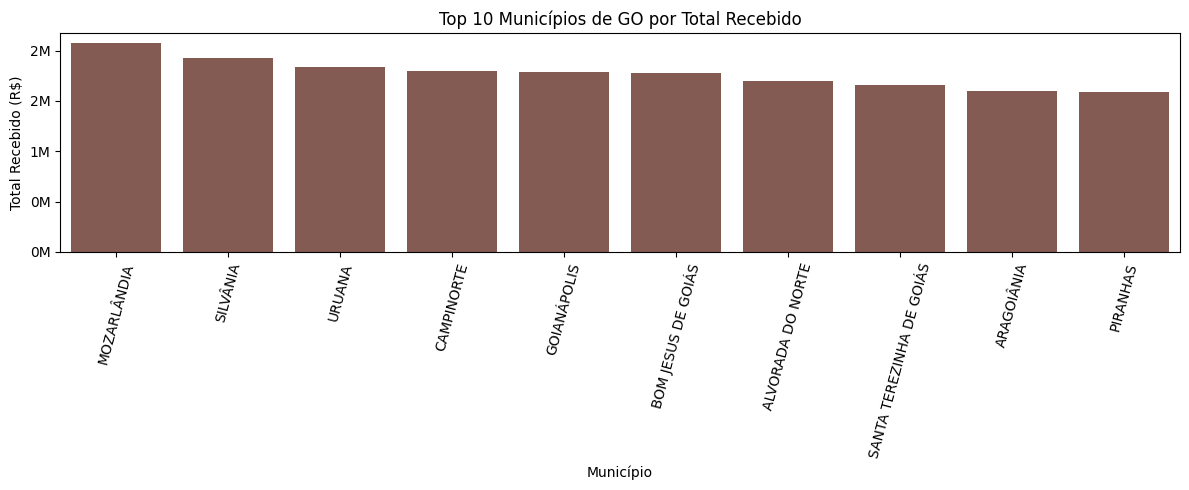

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from pyspark.sql.functions import sum, col, desc

def millions_formatter(x, pos):
    """
    Formats a number as 'X M' (e.g., 1000000 becomes '1 M')
    """
    return f'{x*1e-6:,.0f}M'

# Top 10 Municípios de GO por Total Recebido
pdf_go_municipios = (df.filter(col("UF") == "GO") \
                             .groupBy("Município") \
                             .agg(sum("ValorTransferido").alias("Total")) \
                             .orderBy(desc("Total")) \
                             .limit(10) \
                             .toPandas())

plt.figure(figsize=(12,5))
sns.barplot(data=pdf_go_municipios, x="Município", y="Total", color="#8c564b")
plt.xticks(rotation=75)
plt.title("Top 10 Municípios de GO por Total Recebido")
plt.xlabel("Município")
plt.ylabel("Total Recebido (R$)")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()